In [23]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

In [4]:
df = pd.read_csv(r"C:\Users\ADMIN\Downloads\archive (7)\spam.csv", encoding='cp1252')

df.head(20)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [5]:
df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df.head(10)
df.columns = ['Spam or Ham','Text'] # rename columns
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Spam or Ham  5572 non-null   object
 1   Text         5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


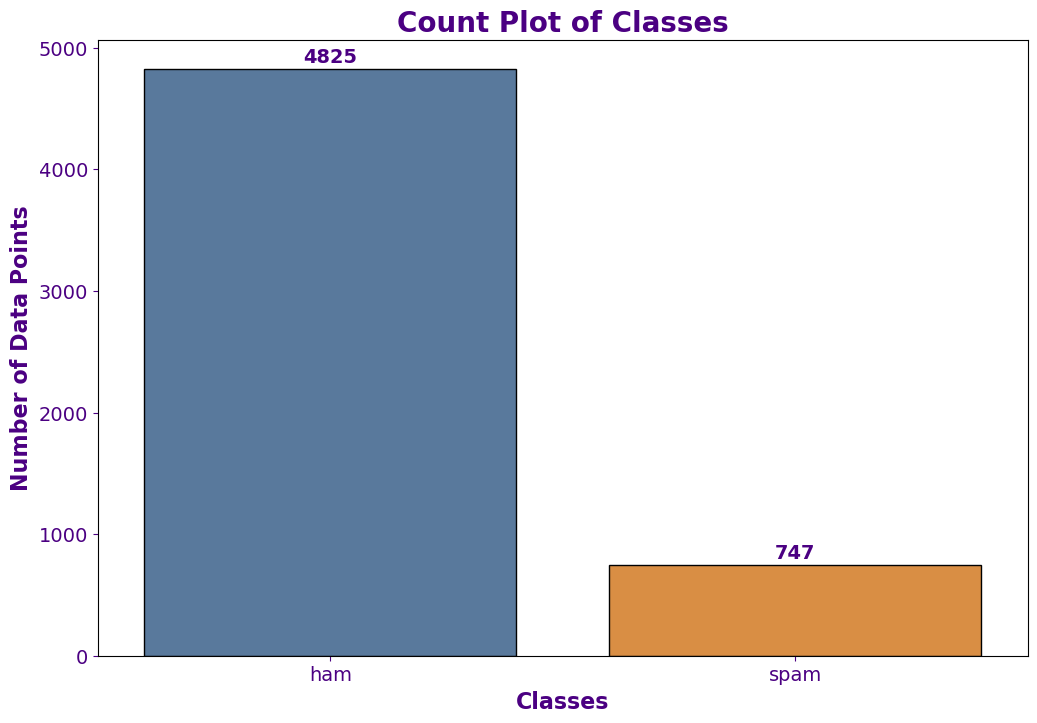

In [6]:
cols = ["#4E79A7", "#F28E2B"]  # Blue and orange colors

# Evaluate the target and find out if our data is balanced
plt.figure(figsize=(12, 8))

# Create the count plot
fg = sns.countplot(x=df["Spam or Ham"], palette=cols, edgecolor="black")

# Set the title and labels
fg.set_title("Count Plot of Classes", color="#4B0082", fontsize=20, fontweight='bold')
fg.set_xlabel("Classes", color="#4B0082", fontsize=16, fontweight='bold')
fg.set_ylabel("Number of Data Points", color="#4B0082", fontsize=16, fontweight='bold')

# Customize the tick parameters for better readability
fg.tick_params(axis='x', colors='#4B0082', labelsize=14)
fg.tick_params(axis='y', colors='#4B0082', labelsize=14)

# Add value labels on the bars
for p in fg.patches:
    fg.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                color="#4B0082", fontsize=14, fontweight='bold')

# Show the plot
plt.show()

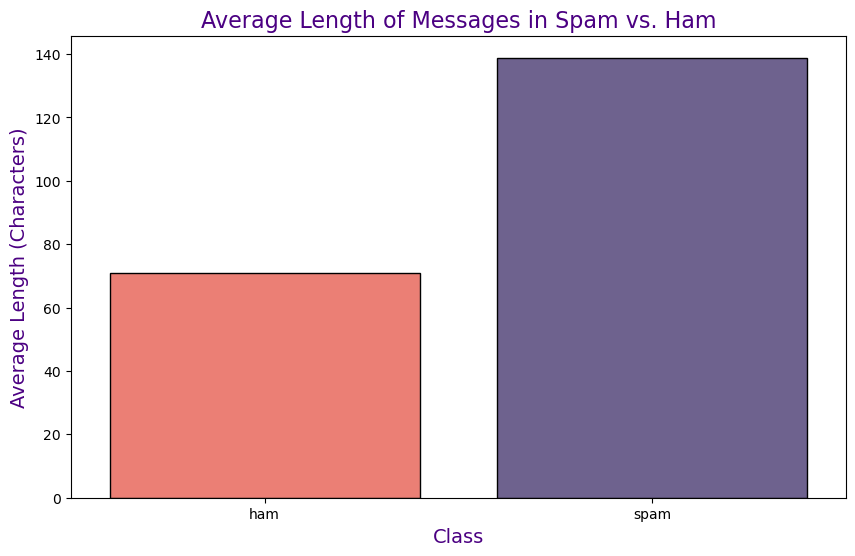

In [7]:
# Set the color palette
palette = ["#FF6F61", "#6B5B95"]

# Add a column for the length of the text
df['Text_Length'] = df['Text'].apply(len)

# Calculate the average length of messages per class
average_length = df.groupby('Spam or Ham')['Text_Length'].mean().reset_index()

# Plot the average length of messages
plt.figure(figsize=(10, 6))
sns.barplot(x='Spam or Ham', y='Text_Length', data=average_length, palette=palette, edgecolor='black')
plt.title('Average Length of Messages in Spam vs. Ham', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Average Length (Characters)', fontsize=14, color='#4B0082')
plt.show()

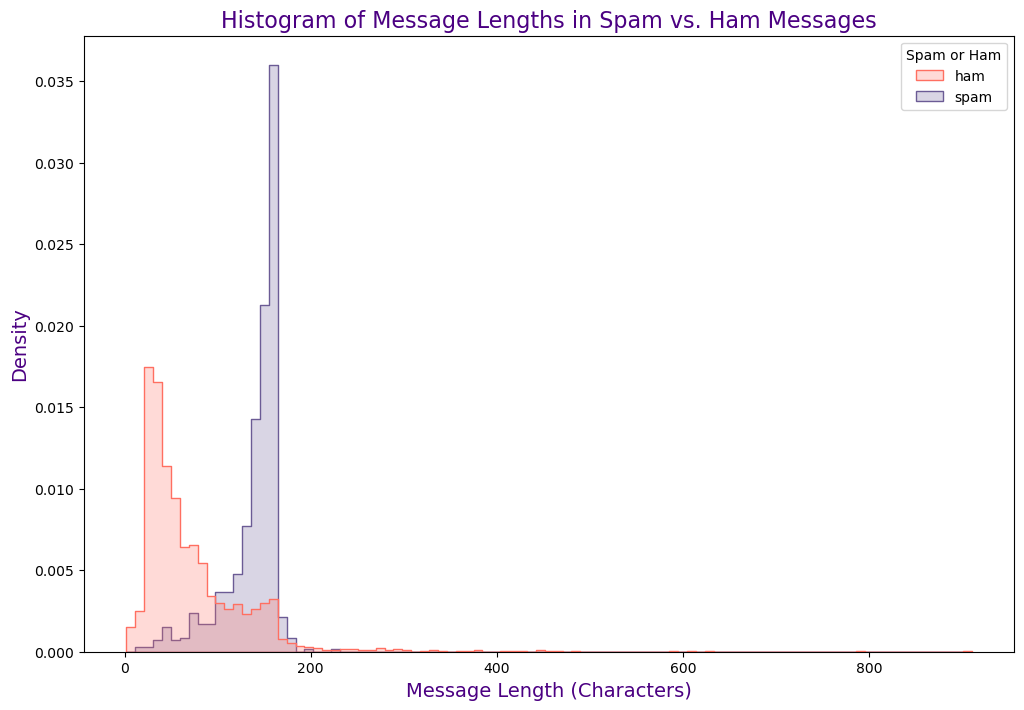

In [8]:
# Plot histogram
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='Text_Length', hue='Spam or Ham', palette=palette, element='step', stat='density', common_norm=False)
plt.title('Histogram of Message Lengths in Spam vs. Ham Messages', fontsize=16, color='#4B0082')
plt.xlabel('Message Length (Characters)', fontsize=14, color='#4B0082')
plt.ylabel('Density', fontsize=14, color='#4B0082')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


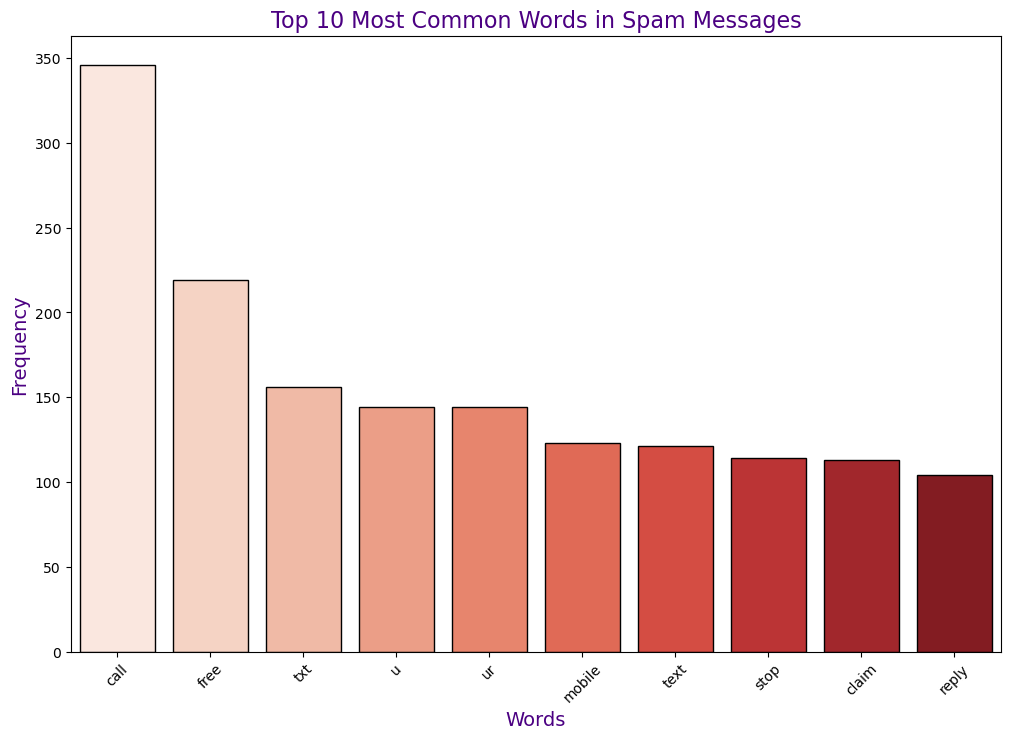

In [9]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Filter spam messages and tokenize
spam_words = ' '.join(df[df['Spam or Ham'] == 'spam']['Text'])
spam_tokens = nltk.word_tokenize(spam_words)

# Remove stop words and non-alphabetic tokens
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in spam_tokens if word.isalpha() and word.lower() not in stop_words]

# Count the most common words
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x=list(words), y=list(counts), palette='Reds', edgecolor='black')
plt.title('Top 10 Most Common Words in Spam Messages', fontsize=16, color='#4B0082')
plt.xlabel('Words', fontsize=14, color='#4B0082')
plt.ylabel('Frequency', fontsize=14, color='#4B0082')
plt.xticks(rotation=45)
plt.show()

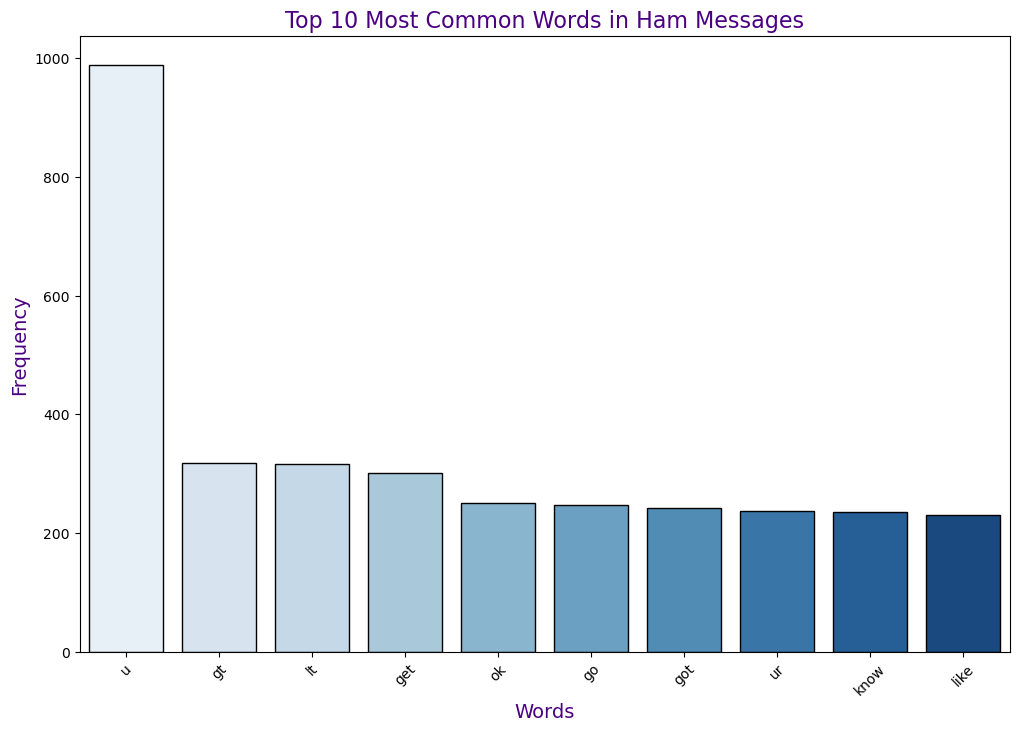

In [10]:
# Filter ham messages and tokenize
ham_words = ' '.join(df[df['Spam or Ham'] == 'ham']['Text'])
ham_tokens = nltk.word_tokenize(ham_words)

# Remove stop words and non-alphabetic tokens
filtered_words = [word.lower() for word in ham_tokens if word.isalpha() and word.lower() not in stop_words]

# Count the most common words
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x=list(words), y=list(counts), palette='Blues', edgecolor='black')
plt.title('Top 10 Most Common Words in Ham Messages', fontsize=16, color='#4B0082')
plt.xlabel('Words', fontsize=14, color='#4B0082')
plt.ylabel('Frequency', fontsize=14, color='#4B0082')
plt.xticks(rotation=45)
plt.show()

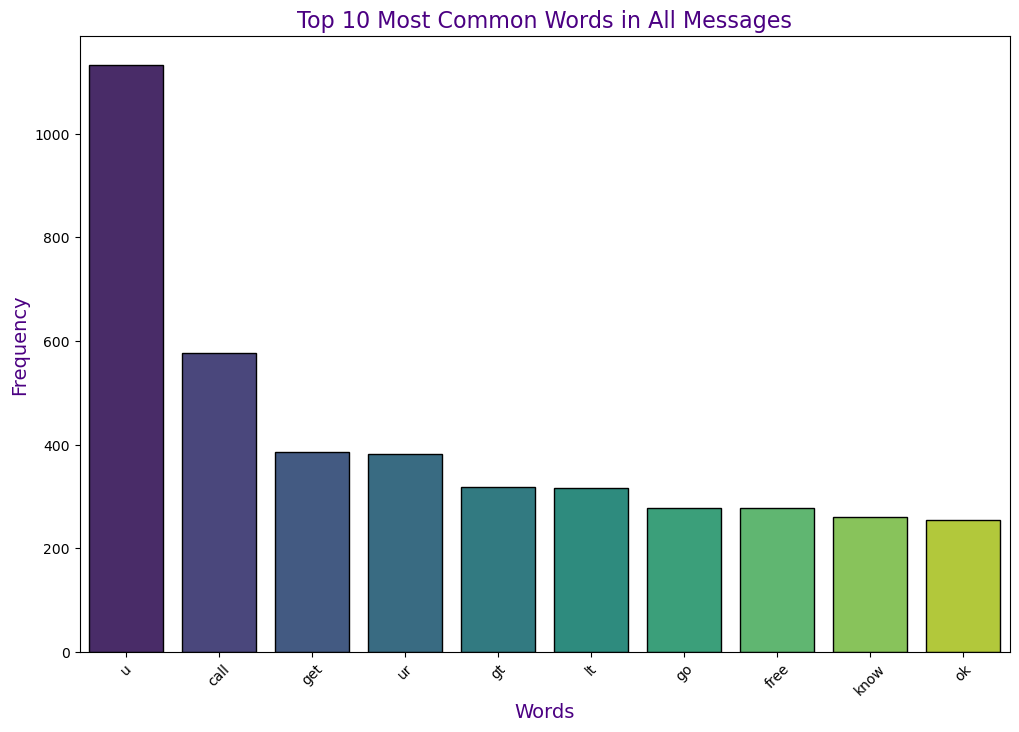

In [11]:
# Combine all text messages and tokenize
all_texts = ' '.join(df['Text'])
all_tokens = nltk.word_tokenize(all_texts)

# Remove stop words and non-alphabetic tokens
filtered_words = [word.lower() for word in all_tokens if word.isalpha() and word.lower() not in stop_words]

# Count the most common words
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x=list(words), y=list(counts), palette='viridis', edgecolor='black')
plt.title('Top 10 Most Common Words in All Messages', fontsize=16, color='#4B0082')
plt.xlabel('Words', fontsize=14, color='#4B0082')
plt.ylabel('Frequency', fontsize=14, color='#4B0082')
plt.xticks(rotation=45)
plt.show()

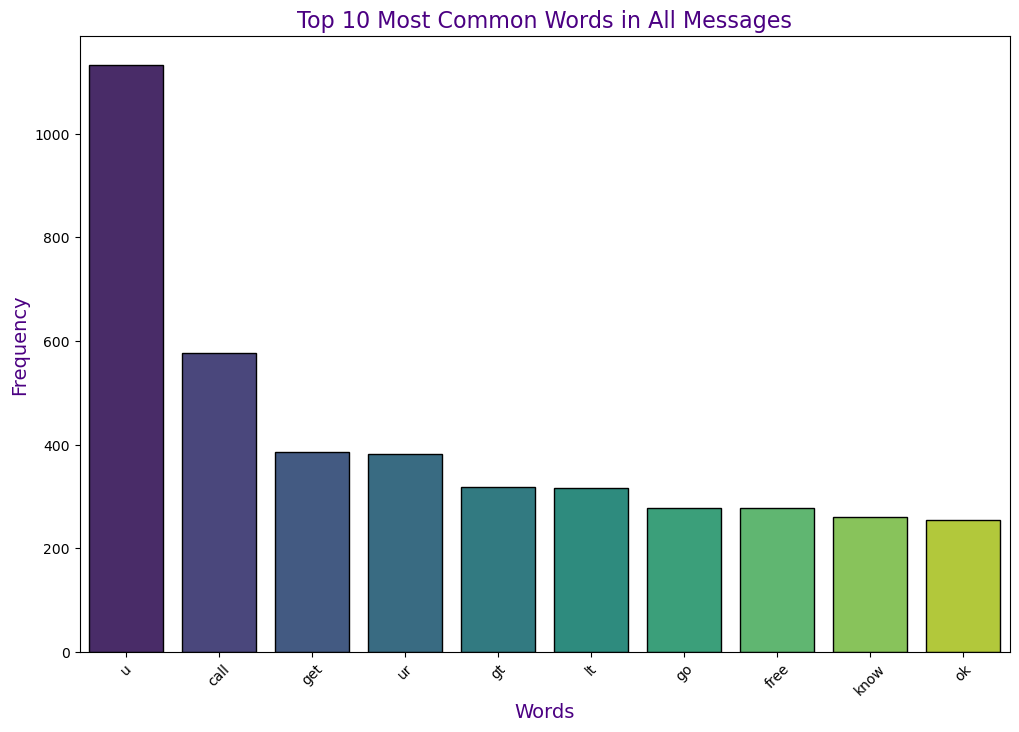

In [12]:
# Combine all text messages and tokenize
all_texts = ' '.join(df['Text'])
all_tokens = nltk.word_tokenize(all_texts)

# Remove stop words and non-alphabetic tokens
filtered_words = [word.lower() for word in all_tokens if word.isalpha() and word.lower() not in stop_words]

# Count the most common words
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x=list(words), y=list(counts), palette='viridis', edgecolor='black')
plt.title('Top 10 Most Common Words in All Messages', fontsize=16, color='#4B0082')
plt.xlabel('Words', fontsize=14, color='#4B0082')
plt.ylabel('Frequency', fontsize=14, color='#4B0082')
plt.xticks(rotation=45)
plt.show()

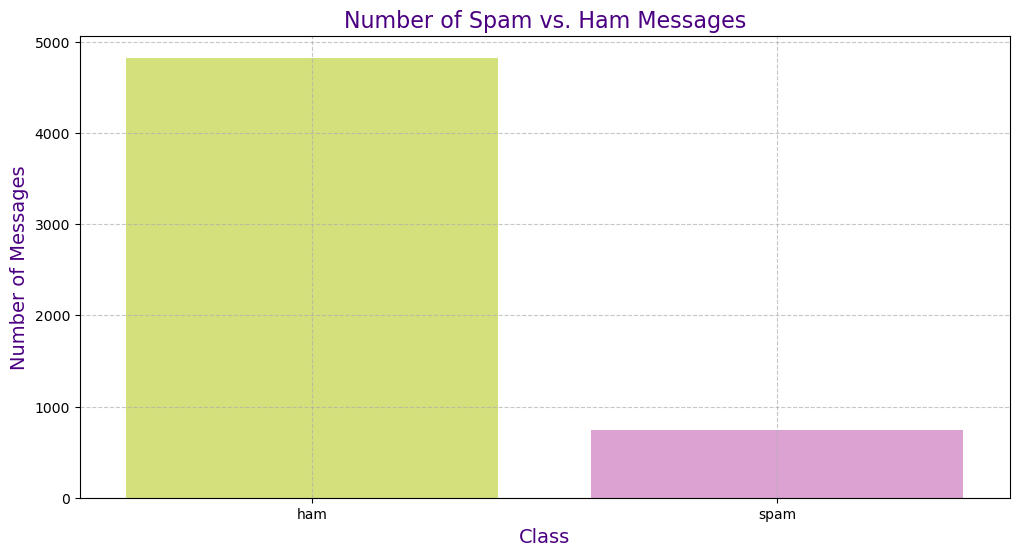

In [13]:
# Plot the count of messages in each class
plt.figure(figsize=(12, 6))
sns.countplot(x='Spam or Ham', data=df, palette=['#E1F16B', '#E598D8'])
plt.title('Number of Spam vs. Ham Messages', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Number of Messages', fontsize=14, color='#4B0082')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

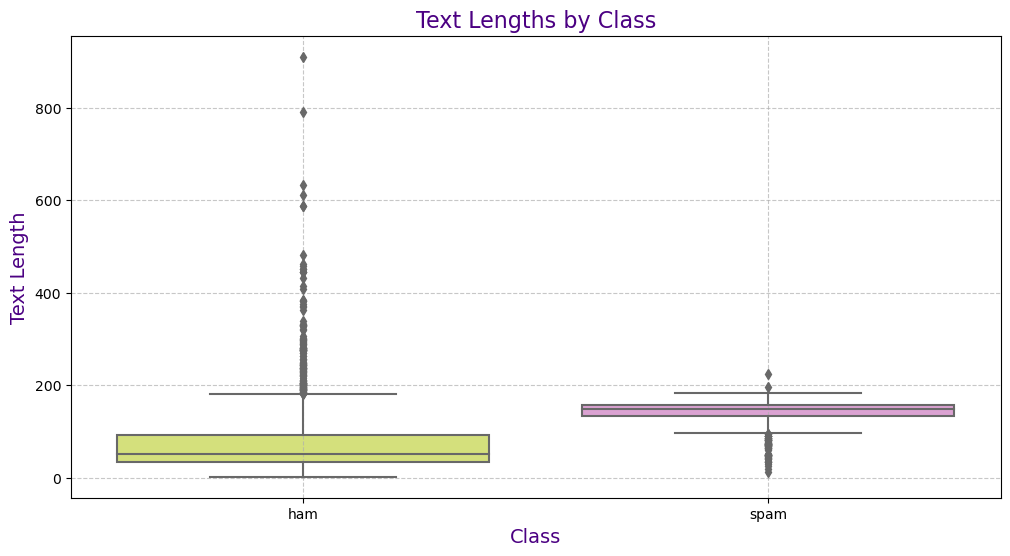

In [14]:
# Plot the distribution of text lengths by class
plt.figure(figsize=(12, 6))
sns.boxplot(x='Spam or Ham', y='Text_Length', data=df, palette=['#E1F16B', '#E598D8'])
plt.title('Text Lengths by Class', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Text Length', fontsize=14, color='#4B0082')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

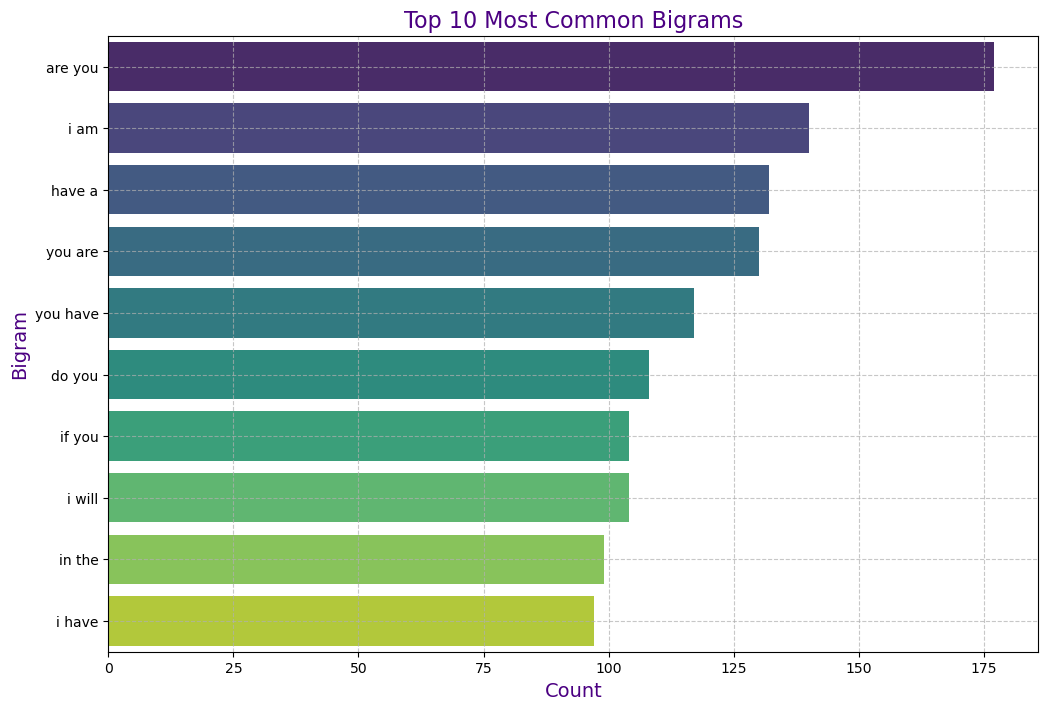

In [15]:
from nltk import bigrams
from nltk import FreqDist

# Tokenize the texts and generate bigrams
all_bigrams = [bigram for text in df['Text'] for bigram in bigrams(nltk.word_tokenize(text.lower())) if bigram[0].isalpha() and bigram[1].isalpha()]

# Get the most common bigrams
bigram_freq = FreqDist(all_bigrams)
most_common_bigrams = bigram_freq.most_common(10)

# Unpack the most common bigrams and their counts
bigrams, counts = zip(*most_common_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]

# Plot the most common bigrams
plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=bigram_labels, palette='viridis')
plt.title('Top 10 Most Common Bigrams', fontsize=16, color='#4B0082')
plt.xlabel('Count', fontsize=14, color='#4B0082')
plt.ylabel('Bigram', fontsize=14, color='#4B0082')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [16]:
# Display basic statistics
text_stats = df.groupby('Spam or Ham').agg({'Text_Length': ['mean', 'std', 'min', 'max', 'median', 'count']})
text_stats.columns = ['Mean Length', 'Std Dev Length', 'Min Length', 'Max Length', 'Median Length', 'Count']
text_stats.style.background_gradient(cmap='viridis').set_caption('Text Length Statistics by Class')

,Mean Length,Std Dev Length,Min Length,Max Length,Median Length,Count
Spam or Ham,,,,,,
ham,71.023627,58.016023,2,910,52.000000,4825
spam,138.866131,29.183082,13,224,149.000000,747


Accuracy: 0.97
Precision: 0.97
Recall: 0.84
F1-score: 0.90


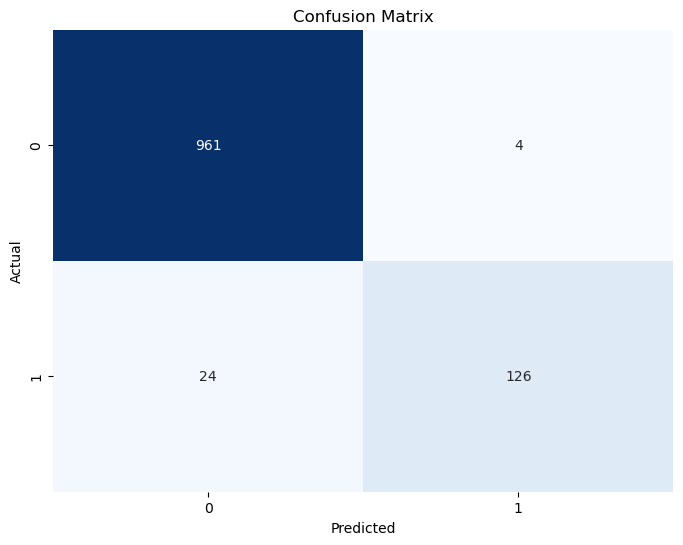

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.84      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [22]:
# Encode categorical labels
label_encoder = LabelEncoder()
df['Spam or Ham'] = label_encoder.fit_transform(df['Spam or Ham'])

# Feature extraction and preprocessing (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['Text'])
y = df['Spam or Ham']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM classifier
svc_classifier = SVC(kernel='linear', random_state=42)
svc_classifier.fit(X_train, y_train)

# Predictions
y_pred = svc_classifier.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Convert label_encoder.classes_ to strings
target_names = [str(label) for label in label_encoder.classes_]

# Print the classification report with the correct target names
print(classification_report(y_test, y_pred, target_names=target_names))